In [ ]:
# Install dependencies.
!pip install -qq --upgrade transformers accelerate diffusers

In [2]:
# Set the details for your model here:
import torch

from diffusers import StableDiffusionXLPipeline, StableDiffusionXLImg2ImgPipeline, AutoencoderKL, KDPM2AncestralDiscreteScheduler

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
base = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
)
refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
)

base2 = StableDiffusionXLImg2ImgPipeline(**base.components)

base.scheduler = KDPM2AncestralDiscreteScheduler.from_config(base.scheduler.config, use_karras_sigmas=True)

_ = base.to("cuda")
_ = base2.to("cuda")
_ = refiner.to("cuda")

torch.cuda.empty_cache()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['ultra realistic, masterpiece, 8 k']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['ultra realistic, masterpiece, 8 k']


  0%|          | 0/8 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece, 8 k']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece, 8 k']


  0%|          | 0/15 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece, 8 k']


  0%|          | 0/7 [00:00<?, ?it/s]

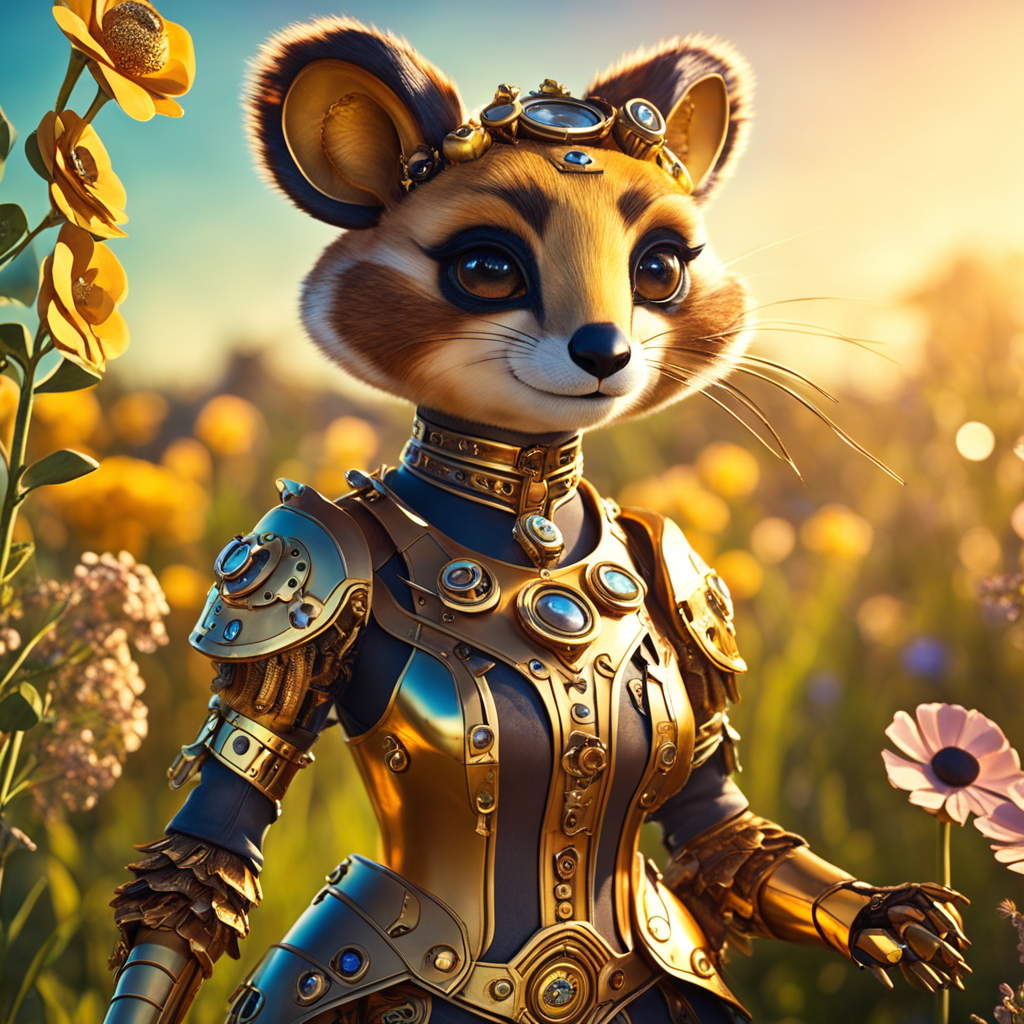

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece, 8 k']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece, 8 k']


  0%|          | 0/15 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece, 8 k']


  0%|          | 0/7 [00:00<?, ?it/s]

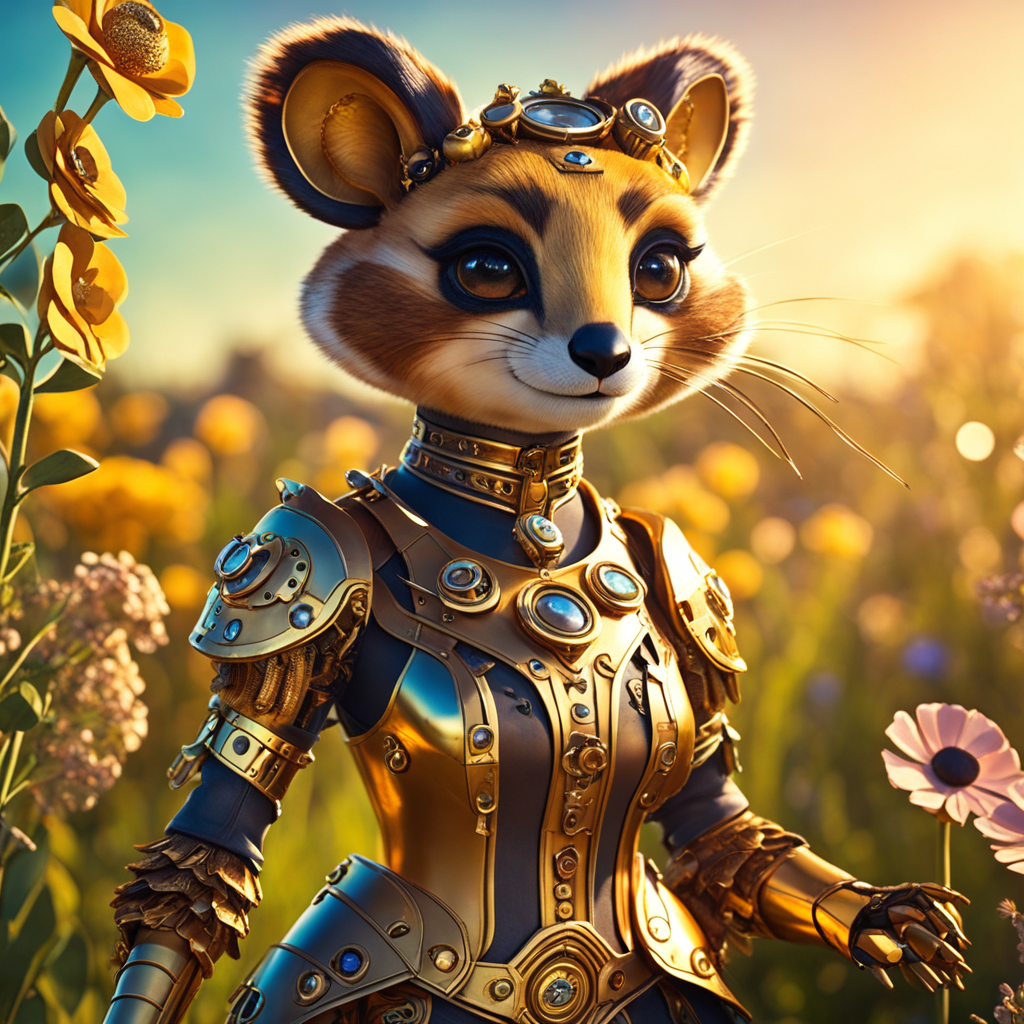

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece, 8 k']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece, 8 k']


  0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [7]:
import os
import zipfile
import random
base.scheduler = base2.scheduler
prompt = f"Steampunk style, photo of stunningly pretty antropomorphic female (suricata) pixar, cute, in (gray) mecha armor looking happy, daylight lush flowers nature park background, golden hour"
quality = "intricate details even to the smallest particle, extreme detail of the enviroment, sharp portrait, well lit, interesting outfit, beautiful shadows, bright, photoquality, ultra realistic, masterpiece, 8k"
negative_prompt = "helmet, ugly, old, boring, photoshopped, tired, wrinkles, scar, gray hair, big forehead, crosseyed, dumb, stupid, cockeyed, disfigured, blurry, assymetrical, unrealistic, grayscale, black and white, bald, high hairline, balding, receeding hairline, grayscale, bad anatomy, unnatural irises, no pupils, blurry eyes, dark eyes, extra limbs, deformed, disfigured eyes, out of frame, no irises, assymetrical face, broken fingers, extra fingers, disfigured hands"
num_samples = 1
guidance_scale = 8
num_inference_steps = 30
height = 1024
width = 1024

prompt = prompt + ". " + quality

def cb(s,t,l):
    print(s,t)

# Set this to the folder you want to save the image to in Google Drive
output_dir = "drive/MyDrive/manually_generated"
os.makedirs(output_dir, exist_ok=True)

threshold = 0.3

latents = base(
    prompt,
    height=height,
    width=width,
    negative_prompt=negative_prompt,
    num_images_per_prompt=num_samples,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    generator=torch.manual_seed(2222),
    output_type = "latent",
    denoising_end=threshold
).images

colors = ["shining golden", "sparkling diamond", "off-white metallic", "radiant ruby", "fuschia"]
for color in colors:
    for animal in ["suricata", "giraffe", "tucan", "turtle"]:
        prompt = prompt.replace("(gray)", color).replace("(suricata)", animal)
        latents_2 = base2(
            prompt,
            negative_prompt=negative_prompt,
            image=latents,
            num_inference_steps=num_inference_steps,
            guidance_scale=20,
            denoising_start=threshold,
            denoising_end=0.8,
            output_type = "latent"
        ).images
        refined = refiner(
            prompt=prompt,
            negative_prompt=negative_prompt,
            image=latents_2,
            num_inference_steps=num_inference_steps,
            denoising_start=0.8
        )
        display(refined.images[0])